In [87]:
import numpy as np
import pandas as pd
from pandas import Series
import datetime
from sklearn import linear_model
from matplotlib import pyplot as plt

In [88]:
sessions_df = pd.read_json("./../data/raw/sessions.jsonl", lines=True)
sessions_df.set_index('session_id', inplace=True)

In [89]:
def create_weeks(df):
    dates = df['timestamp']
    dates = pd.to_datetime(dates)
    dates = dates.dt.to_period('W')
    dates = dates.drop_duplicates()
    dates = dates.sort_values()
    return dates

In [90]:
def calculate_week_number(date = datetime.date.today()):
    first_date = create_weeks(sessions_df).values[0].start_time.date()
    return (date - first_date).days//7

In [91]:
def product_bought(product_id, df, dates):
    product_amount = df[(df['event_type'] == "BUY_PRODUCT") & (df['product_id'] == product_id)]
    daterange_df = pd.DataFrame()
    time_list = [(dates.values[i].start_time, dates.values[i].end_time) for i in range(len(dates))]
    daterange_df['count'] = [product_amount['timestamp'].between(s, e).sum() for s, e in time_list]
    return daterange_df

In [92]:
def prepare_dataframe(df):
    dates = create_weeks(df)
    weeks = dates.values
    df3 = pd.DataFrame()
    df3['date'] = [weeks[i].start_time for i in range(len(weeks))]
    df2 = pd.DataFrame(index = df3['date'])
    df2['weeks_from_start'] = ((df2.index - df2.index[0]).days)//7
    return df2, dates

In [93]:
def prepare_data(product_id, df, source_df, dates):
    x = df['weeks_from_start'].values.reshape(-1, 1)
    y = product_bought(product_id, source_df, dates)['count'].values
    return x, y

In [94]:
df, dates = prepare_dataframe(sessions_df)
x, y = prepare_data(1291, df, sessions_df, dates)

In [95]:
df # weeks from start
y = product_bought(1291, sessions_df, dates) # ile produktu o danym id zostało kupione w danym tygodniu

In [106]:
y
split_n = int(0.8*len(y))
train = y.iloc[:split_n]
test = y.iloc[split_n:]

In [108]:
train

,count
0,0
1,6
2,14
3,1
4,21
...,...
94,0
95,0
96,0
97,0


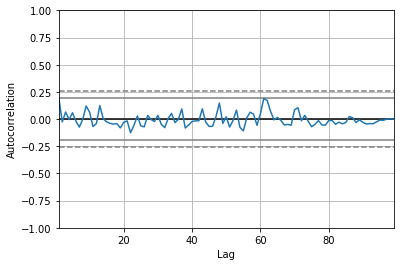

In [109]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train['count'])
plt.show()

In [110]:
#!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA


In [111]:
model=ARIMA(train['count'],order=(1,1,1))
model_fit=model.fit()

In [112]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -306.796
Date:                Mon, 10 Jan 2022   AIC                            619.592
Time:                        14:58:36   BIC                            627.347
Sample:                             0   HQIC                           622.728
                                 - 99                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1822      0.081      2.252      0.024       0.024       0.341
ma.L1         -0.9654      0.069    -13.948      0.000      -1.101      -0.830
sigma2        29.9476      4.504      6.650      0.000      21.121      38.775
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                87.01
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             1.77
Prob(H) (two-sided):                  0.12   Kurtosis:                         5.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [113]:
for i in range(98, 150):
    train.loc[len(train)] = 0

C:\Users\ewaka\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


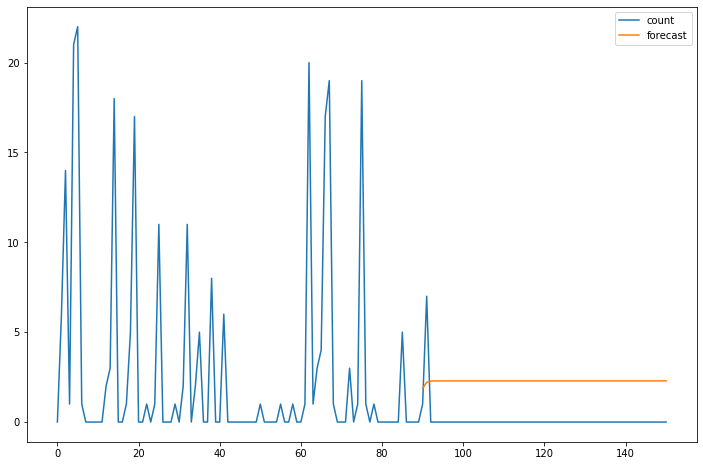

In [114]:
train['forecast']=model_fit.predict(start=90,end=150,dynamic=True)
train[['count','forecast']].plot(figsize=(12,8))

In [115]:
train['forecast'][100]

2.289648894820419

In [116]:
test

,count
99,0
100,0
101,0
102,0
103,0
104,0
105,0
106,0
107,0
108,0


In [118]:
test['count']

99      0
100     0
101     0
102     0
103     0
104     0
105     0
106     0
107     0
108     0
109     0
110     0
111     0
112     1
113     0
114     1
115     1
116     2
117     0
118     2
119     0
120    10
121    29
122     3
123     9
Name: count, dtype: int64

In [53]:
y['forecast'][130]

2.6886511257427674